In [113]:
#!pip install pmdarima

### 1) Import the necessary libraries

In [114]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import pmdarima as pm

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [115]:
def chart(x,y,name):
    fig.add_trace(go.Scatter(x=x, y=y,mode='lines', name=name))
    return chart

In [116]:
# Define slider function for charts
def slider(x):
    x.update_xaxes(
        rangeslider_visible=True,
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(count=5, label="5y", step="year", stepmode="backward"),
                dict(count=10, label="10y", step="year", stepmode="backward"),
                dict(count=15, label="15y", step="year", stepmode="backward"),
                dict(count=25, label="25y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        )
    )

    return slider

### 2) Importing the files from the saved location

#### - Qtrly data

In [117]:
df_qtr=pd.read_csv('./Data/Qtr_US.csv',parse_dates=['Date'],index_col='Date').drop('Unnamed: 0',axis=1)

In [118]:
df_qtr.tail()

,PMI,NMI,Consumer_sen,building_permits,Unemployment,Non_Farm,Initial_Claims,Continuing_Claims,SnP500,VIX,Net_Export,int_spread,Real_GDP
Date,,,,,,,,,,,,,
2019-06-30,52.433333,55.833333,98.466667,1313.666667,5924.333333,150609.333333,2.184615e+05,1.685231e+06,2882.327778,15.183016,-662.660,-0.063333,19021.860
2019-09-30,49.433333,54.400000,93.800000,1424.666667,5926.333333,151160.333333,2.144615e+05,1.688462e+06,2957.836406,15.960156,-653.032,-0.393333,19121.112
2019-12-31,48.133333,54.400000,97.200000,1490.000000,5807.000000,151788.333333,2.183077e+05,1.706154e+06,3082.755625,13.985781,-577.867,0.150000,19221.970
2020-03-31,50.033333,55.100000,96.633333,1443.333333,6273.000000,151921.666667,9.673077e+05,2.266231e+06,3055.869194,31.224516,-526.154,0.123333,18974.702
2020-06-30,42.300000,43.600000,71.800000,1143.000000,22031.500000,131657.500000,3.233091e+06,1.988400e+07,2916.986491,34.714561,NaN,0.615000,NaN


#### Analysis on qtrly data

In [119]:
df_qtr.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 289 entries, 1948-06-30 to 2020-06-30
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PMI                289 non-null    float64
 1   NMI                91 non-null     float64
 2   Consumer_sen       252 non-null    float64
 3   building_permits   241 non-null    float64
 4   Unemployment       289 non-null    float64
 5   Non_Farm           289 non-null    float64
 6   Initial_Claims     213 non-null    float64
 7   Continuing_Claims  213 non-null    float64
 8   SnP500             289 non-null    float64
 9   VIX                121 non-null    float64
 10  Net_Export         288 non-null    float64
 11  int_spread         263 non-null    float64
 12  Real_GDP           288 non-null    float64
dtypes: float64(13)
memory usage: 31.6 KB


In [120]:
df_qtr.isnull().sum()/df_qtr.isnull().count()

PMI                  0.000000
NMI                  0.685121
Consumer_sen         0.128028
building_permits     0.166090
Unemployment         0.000000
Non_Farm             0.000000
Initial_Claims       0.262976
Continuing_Claims    0.262976
SnP500               0.000000
VIX                  0.581315
Net_Export           0.003460
int_spread           0.089965
Real_GDP             0.003460
dtype: float64

#### Note:
- The missing values were mainly in NMI and VIX. NMI index started in 1997 while VIX started in 1990.
- initial and continuing claims started in 1967.
- Export, GDP data avail on quarterly basis.  

#### Decision: We will remove the columns "NMI" and "VIX" as there are > 50% missing data

In [121]:
df_qtr=df_qtr.drop(["NMI",'VIX'],axis=1)

In [122]:
df_qtr=df_qtr.loc[df_qtr['Real_GDP'].notnull()]

#### Columns with no. of missing values

In [123]:
df_qtr.isnull().sum()

PMI                   0
Consumer_sen         37
building_permits     48
Unemployment          0
Non_Farm              0
Initial_Claims       76
Continuing_Claims    76
SnP500                0
Net_Export            0
int_spread           26
Real_GDP              0
dtype: int64

In [124]:
df_qtr.corr()

,PMI,Consumer_sen,building_permits,Unemployment,Non_Farm,Initial_Claims,Continuing_Claims,SnP500,Net_Export,int_spread,Real_GDP
PMI,1.000000,0.400640,0.340210,-0.114302,-0.067233,-0.510070,-0.355736,0.009806,0.003545,0.087457,-0.035129
Consumer_sen,0.400640,1.000000,0.438189,-0.455821,-0.002604,-0.505123,-0.530626,0.165974,0.012170,0.076832,-0.002580
building_permits,0.340210,0.438189,1.000000,-0.350758,-0.003429,-0.348787,-0.445018,-0.058951,-0.007110,-0.052335,-0.077196
Unemployment,-0.114302,-0.455821,-0.350758,1.000000,0.707012,0.592795,0.853009,0.424825,-0.530375,0.480279,0.682199
Non_Farm,-0.067233,-0.002604,-0.003429,0.707012,1.000000,0.020654,0.217114,0.848380,-0.833971,0.226717,0.978710
Initial_Claims,-0.510070,-0.505123,-0.348787,0.592795,0.020654,1.000000,0.788897,-0.179222,0.072504,0.200399,-0.026869
Continuing_Claims,-0.355736,-0.530626,-0.445018,0.853009,0.217114,0.788897,1.000000,-0.038504,-0.165430,0.447248,0.199081
SnP500,0.009806,0.165974,-0.058951,0.424825,0.848380,-0.179222,-0.038504,1.000000,-0.870119,0.160251,0.919323
Net_Export,0.003545,0.012170,-0.007110,-0.530375,-0.833971,0.072504,-0.165430,-0.870119,1.000000,-0.222875,-0.903868
int_spread,0.087457,0.076832,-0.052335,0.480279,0.226717,0.200399,0.447248,0.160251,-0.222875,1.000000,0.256035


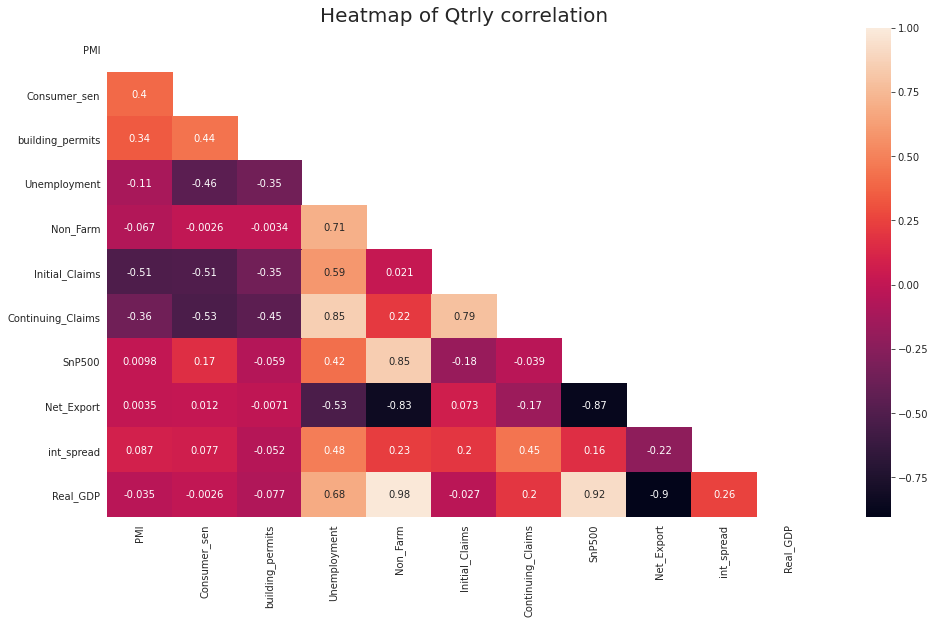

In [125]:
plt.figure(figsize=(16,9))

mask = np.zeros_like(df_qtr.corr())
#mask 
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(df_qtr.corr(),mask=mask, annot=True) 
    ax.set_title("Heatmap of Qtrly correlation", fontsize=20);

#### Decision: Drop all NA values (quarterly data from 1967-06-30-2020-03-31) 

In [126]:
dfq=df_qtr.dropna()

In [127]:
dfq.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 212 entries, 1967-06-30 to 2020-03-31
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PMI                212 non-null    float64
 1   Consumer_sen       212 non-null    float64
 2   building_permits   212 non-null    float64
 3   Unemployment       212 non-null    float64
 4   Non_Farm           212 non-null    float64
 5   Initial_Claims     212 non-null    float64
 6   Continuing_Claims  212 non-null    float64
 7   SnP500             212 non-null    float64
 8   Net_Export         212 non-null    float64
 9   int_spread         212 non-null    float64
 10  Real_GDP           212 non-null    float64
dtypes: float64(11)
memory usage: 19.9 KB


In [128]:
dfq_diff=dfq.pct_change()

In [129]:
ss = StandardScaler()
scaled_dfq = ss.fit_transform(dfq_diff)
scaled_dfq = pd.DataFrame(scaled_dfq)
scaled_dfq.columns=dfq_diff.columns
scaled_dfq['Date']=dfq_diff.index
scaled_dfq.set_index('Date',inplace=True)

In [130]:
fig = go.Figure()

chart(scaled_dfq.index,scaled_dfq['PMI'],'PMI')
chart(scaled_dfq.index,scaled_dfq['Consumer_sen'],'Consumer_sentiment')
chart(scaled_dfq.index,scaled_dfq['building_permits'],'Building_permits')
chart(scaled_dfq.index,scaled_dfq['Unemployment'],'Unemployment')
chart(scaled_dfq.index,scaled_dfq['Non_Farm'],'Non_Farm')
chart(scaled_dfq.index,scaled_dfq['Initial_Claims'],'Initial_Claims')
chart(scaled_dfq.index,scaled_dfq['Continuing_Claims'],'Continuing_Claims')
chart(scaled_dfq.index,scaled_dfq['SnP500'],'S&P 500')
chart(scaled_dfq.index,scaled_dfq['Net_Export'],'Net Export')
chart(scaled_dfq.index,scaled_dfq['int_spread'],'Interest_spread')
chart(scaled_dfq.index,scaled_dfq['Real_GDP'],'Real_GDP')


# Edit the layout
fig.update_layout(title='Correlation of Quarterly Indexes',
                   xaxis_title='Period',
                   yaxis_title='% Change')

slider(fig)
fig.show()

In [131]:
dfq.head()

,PMI,Consumer_sen,building_permits,Unemployment,Non_Farm,Initial_Claims,Continuing_Claims,SnP500,Net_Export,int_spread,Real_GDP
Date,,,,,,,,,,,
1967-06-30,44.700000,95.9,1093.333333,2938.666667,65612.000000,245076.923077,1.269154e+06,91.683125,4.219,0.830000,4538.370
1967-09-30,52.200000,97.0,1228.333333,2949.000000,66065.000000,219428.571429,1.212500e+06,94.433651,3.302,1.353333,4581.309
1967-12-31,54.633333,92.9,1297.333333,3075.666667,66609.333333,211384.615385,1.164231e+06,94.568871,2.244,1.470000,4615.853
1968-03-31,55.133333,97.2,1297.000000,2918.666667,67104.666667,206307.692308,1.157308e+06,91.717742,1.054,0.823333,4709.993
1968-06-30,55.600000,92.4,1294.333333,2795.666667,67704.333333,196923.076923,1.072846e+06,97.914068,1.749,-0.236667,4788.688


#### Bring in the predicted quarter from last avail mth

In [132]:
df=pd.read_csv('./Data/US.csv',parse_dates=['Date'],index_col='Date').drop('Unnamed: 0',axis=1)

In [133]:
df=df.drop(["NMI",'VIX'],axis=1)

#### Data Imputation for missing monthly values

In [134]:
#https://tradingeconomics.com/united-states/consumer-confidence
df.loc[df.index=='2020-05-31','Consumer_sen']=72.3

In [135]:
df=df.interpolate(method='linear')

#### Monthly Data preparation to be appended to quarterly data

In [136]:
df=df[-1:]

In [137]:
df=df.drop('GDP_Growth_Rate',axis=1)

In [138]:
#Update date to next quarter end
df.index=df.index+ pd.offsets.QuarterEnd()

#### Append data to quarterly data

In [139]:
dfq=dfq.append(df)

In [140]:
data= dfq['Real_GDP'][:-1]
data=pd.DataFrame(data)

In [141]:
data.head()

,Real_GDP
Date,
1967-06-30,4538.370
1967-09-30,4581.309
1967-12-31,4615.853
1968-03-31,4709.993
1968-06-30,4788.688


In [142]:
# Create first_diff_gdp and second_diff_gdp
data['first_diff_gdp'] = data['Real_GDP'].diff(1)
data['second_diff_gdp'] = data['Real_GDP'].diff(1).diff(1)

In [143]:
data.tail()

,Real_GDP,first_diff_gdp,second_diff_gdp
Date,,,
2019-03-31,18927.281,143.733,92.905
2019-06-30,19021.860,94.579,-49.154
2019-09-30,19121.112,99.252,4.673
2019-12-31,19221.970,100.858,1.606
2020-03-31,18974.702,-247.268,-348.126


In [144]:
# Code modified from code written by Matthew Garton.

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (12, 6).
    plt.figure(figsize=(12,6))
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=20)
    plt.xlabel(xlab, fontsize=10)
    plt.ylabel(ylab, fontsize=10)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=14)
    plt.xticks(df.index[0::steps], fontsize=14);

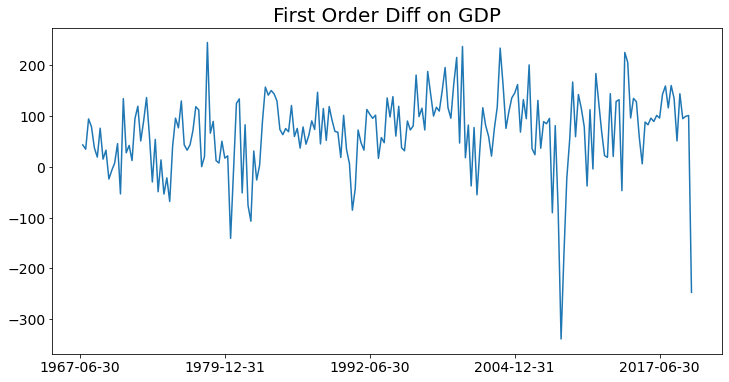

In [145]:
plot_series(data,['first_diff_gdp'],title='First Order Diff on GDP',steps=50)

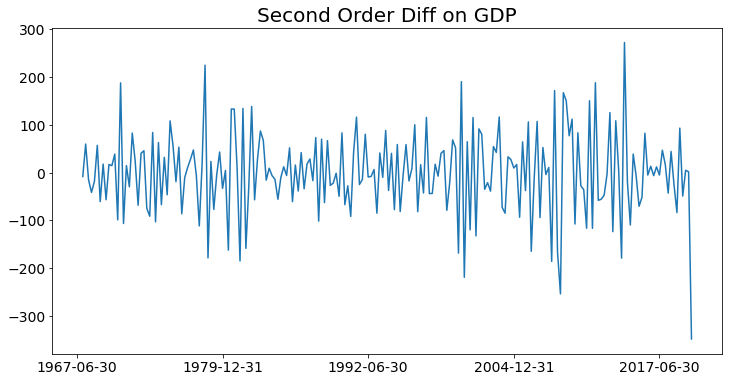

In [146]:
plot_series(data,['second_diff_gdp'],title='Second Order Diff on GDP',steps=50)

#### Checking for Stationarity: the Augmented Dickey-Fuller Test

The [augmented Dickey-Fuller test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) is a hypothesis test that tests for stationarity. We assume that our data are not stationary. With enough evidence, we may accept that our data are stationary.

Specifically, the test is as follows:

$$
\begin{eqnarray}
&H_0:& \text{not stationary} \\
&H_A:& \text{stationary}
\end{eqnarray}
$$

In [147]:
# Import Augmented Dickey-Fuller test.
from statsmodels.tsa.stattools import adfuller


def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

# Run ADF test on original (non-differenced!) data.
interpret_dftest(adfuller(data['Real_GDP']))


Test Statistic    0.919266
p-value           0.993337
dtype: float64

#### tested on 1st_order diff

In [148]:
interpret_dftest(adfuller(data['first_diff_gdp'].dropna()))

Test Statistic   -6.466066e+00
p-value           1.404309e-08
dtype: float64

#### tested on 2nd_order diff

In [149]:
interpret_dftest(adfuller(data['second_diff_gdp'].dropna()))

Test Statistic   -7.394266e+00
p-value           7.853123e-11
dtype: float64

#### Observation
- With a  𝑝 -value of well below 0.05, we would reject  𝐻0  and thus accept that our first-order differenced data are stationary.

### Preparation for modelling
#### Train_Test_Split

In [150]:
test_size=0.1

In [151]:
train, test = train_test_split(dfq,test_size= test_size,shuffle=False)

In [152]:
train.head()

,PMI,Consumer_sen,building_permits,Unemployment,Non_Farm,Initial_Claims,Continuing_Claims,SnP500,Net_Export,int_spread,Real_GDP
Date,,,,,,,,,,,
1967-06-30,44.700000,95.9,1093.333333,2938.666667,65612.000000,245076.923077,1.269154e+06,91.683125,4.219,0.830000,4538.370
1967-09-30,52.200000,97.0,1228.333333,2949.000000,66065.000000,219428.571429,1.212500e+06,94.433651,3.302,1.353333,4581.309
1967-12-31,54.633333,92.9,1297.333333,3075.666667,66609.333333,211384.615385,1.164231e+06,94.568871,2.244,1.470000,4615.853
1968-03-31,55.133333,97.2,1297.000000,2918.666667,67104.666667,206307.692308,1.157308e+06,91.717742,1.054,0.823333,4709.993
1968-06-30,55.600000,92.4,1294.333333,2795.666667,67704.333333,196923.076923,1.072846e+06,97.914068,1.749,-0.236667,4788.688


In [153]:
test.tail()

,PMI,Consumer_sen,building_permits,Unemployment,Non_Farm,Initial_Claims,Continuing_Claims,SnP500,Net_Export,int_spread,Real_GDP
Date,,,,,,,,,,,
2019-06-30,52.433333,98.466667,1313.666667,5924.333333,150609.333333,2.184615e+05,1.685231e+06,2882.327778,-662.660,-0.063333,19021.860
2019-09-30,49.433333,93.800000,1424.666667,5926.333333,151160.333333,2.144615e+05,1.688462e+06,2957.836406,-653.032,-0.393333,19121.112
2019-12-31,48.133333,97.200000,1490.000000,5807.000000,151788.333333,2.183077e+05,1.706154e+06,3082.755625,-577.867,0.150000,19221.970
2020-03-31,50.033333,96.633333,1443.333333,6273.000000,151921.666667,9.673077e+05,2.266231e+06,3055.869194,-526.154,0.123333,18974.702
2020-06-30,43.100000,72.300000,1220.000000,20985.000000,132912.000000,2.465800e+06,2.203500e+07,2919.608500,-526.154,0.620000,18974.702


In [154]:
train.shape

(191, 11)

In [155]:
test.shape

(22, 11)

#### Manual Grid Search for best p & q

In [156]:
# Starting AIC, p, and q.
best_aic = 99 * (10**16)
best_p = 0
best_q =0

# Use nested for loop to iterate over values of p and q.
for p in range(5):
    for q in range(5):
        
        # Insert try and except statements.
        try:
            
            # Fitting an ARIMA(p, 1, q) model.
            print(f'Attempting ARIMA({p},1,{q})')
            
            # Instantiate ARIMA model.
           # arima = ARIMA(y_train.astype(float).dropna(),order=(p,1,q))
            arima = ARIMA(train['Real_GDP'],order=(p,1,q))
            
            
            # Fit ARIMA model.
            model = arima.fit()

            # Print out AIC for ARIMA(p, 1, q) model.
            print(f'The AIC for ARIMA({p},1,{q}) is: {model.aic}')

            # Is my current model's AIC better than our best_aic?
            if model.aic < best_aic:
                
                # If so, let's overwrite best_aic, best_p, and best_q.
                best_aic = model.aic
                best_p = p
                best_q =q

        except:
            pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},1,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

Attempting ARIMA(0,1,0)
Attempting ARIMA(0,1,1)
Attempting ARIMA(0,1,2)
Attempting ARIMA(0,1,3)
Attempting ARIMA(0,1,4)
Attempting ARIMA(1,1,0)
Attempting ARIMA(1,1,1)
Attempting ARIMA(1,1,2)
Attempting ARIMA(1,1,3)
Attempting ARIMA(1,1,4)
Attempting ARIMA(2,1,0)
Attempting ARIMA(2,1,1)
Attempting ARIMA(2,1,2)
Attempting ARIMA(2,1,3)
Attempting ARIMA(2,1,4)
Attempting ARIMA(3,1,0)
Attempting ARIMA(3,1,1)
Attempting ARIMA(3,1,2)
Attempting ARIMA(3,1,3)
Attempting ARIMA(3,1,4)
Attempting ARIMA(4,1,0)
Attempting ARIMA(4,1,1)
Attempting ARIMA(4,1,2)
Attempting ARIMA(4,1,3)
Attempting ARIMA(4,1,4)


MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(0,1,0).
This model has an AIC of 990000000000000000.


#### Instantiate best model

In [157]:
sarimax=SARIMAX(endog=train['Real_GDP'],order=(0,1,0),seasonal_order=(0,1,0,4),
                      exog=train[['PMI', 'Consumer_sen', 'building_permits', 'Unemployment', 
                                'Non_Farm','Initial_Claims', 'Continuing_Claims', 'SnP500', 
                                'Net_Export','int_spread']],freq='Q')

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency Q-DEC will be used.



#### Fitting the model

In [158]:
model = sarimax.fit()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



#### Predicting the test data

In [159]:
start= int(round(len(dfq)-test_size*len(dfq),0)-2)

In [160]:
end=int(len(dfq)-1)

In [161]:
preds = model.predict(start=start,end=end,exog=test[['PMI', 'Consumer_sen', 'building_permits', 'Unemployment', 
                                'Non_Farm','Initial_Claims', 'Continuing_Claims', 'SnP500', 'Net_Export','int_spread']])

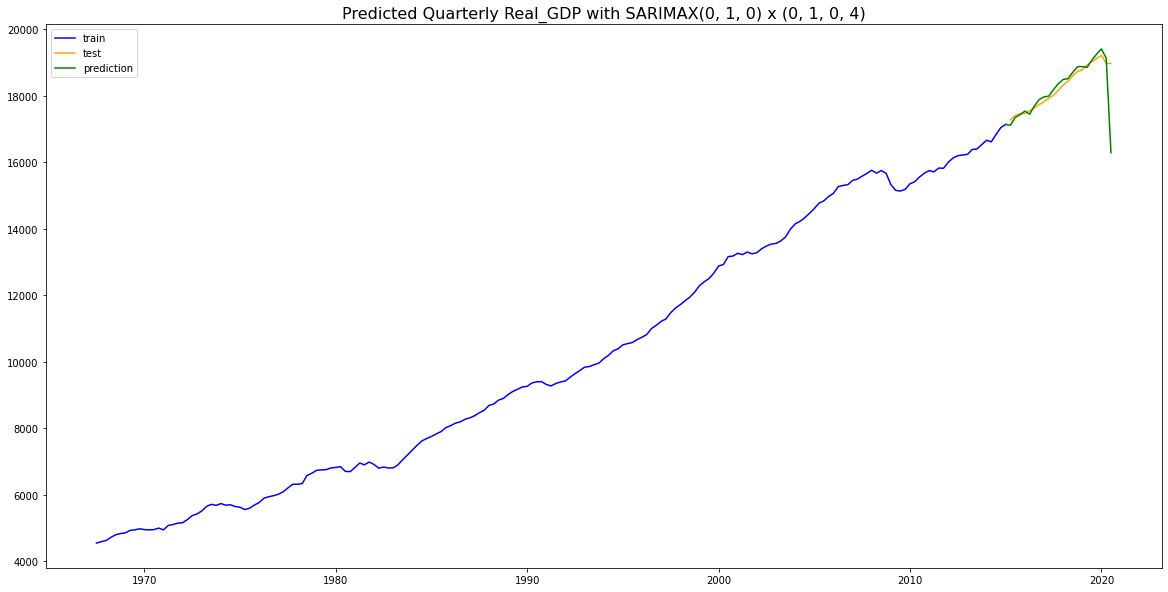

In [185]:
# Plot data.
plt.figure(figsize=(20,10))
plt.plot(train['Real_GDP'], color = 'blue',label='train')
plt.plot(test['Real_GDP'], color = 'orange',label='test')
plt.plot(preds, color = 'green',label='prediction')
plt.title(label = 'Predicted Quarterly Real_GDP with SARIMAX(0, 1, 0) x (0, 1, 0, 4)', fontsize=16)
plt.legend()
plt.show();

In [163]:
preds.tail()

2019-06-30    19074.987905
2019-09-30    19254.563128
2019-12-31    19413.160183
2020-03-31    19133.423717
2020-06-30    16289.791937
Freq: Q-DEC, dtype: float64

#### Predicted last quarterly US GDP % diff

In [164]:
pct_diff=round((preds[-1]/preds[-2]-1)*100,3)
pct_diff

-14.862

In [165]:
sarimax_compare=pd.DataFrame(test['Real_GDP'])

In [166]:
sarimax_pred=pd.DataFrame(preds,columns=['yhat'])

In [167]:
sarimax_compare['yhat']=sarimax_pred['yhat']

In [168]:
sarimax_compare=sarimax_compare[:-1]

In [186]:
sarimax_compare.head()

,Real_GDP,yhat
Date,,
2015-03-31,17277.580,17117.778080
2015-06-30,17405.669,17348.149808
2015-09-30,17463.222,17432.444353
2015-12-31,17468.902,17541.817225
2016-03-31,17556.839,17448.461107


In [169]:
r2=r2_score(sarimax_compare['Real_GDP'], sarimax_compare['yhat'])
mse=mean_squared_error(sarimax_compare['Real_GDP'], sarimax_compare['yhat'])
rmse = np.sqrt(mse) 
mae=mean_absolute_error(sarimax_compare['Real_GDP'], sarimax_compare['yhat'])


print(f'r2: {r2}')
print(f'mean_squared_error: {mse}')
print(f'root_mean_squared_error: {rmse}')
print(f'mean_absolute_error: {mae}')

r2: 0.9597030923907865
mean_squared_error: 15920.682407747006
root_mean_squared_error: 126.17718655821665
mean_absolute_error: 115.69635704264164


### Observation:

- For this data, we get an R-Squared value of 0.959, it can be interpreted that ~96% of the variance in this data is explained by the model. However, it could also indicate that the model is overfitted.

- With a RMSE of 126, the model is giving an accurate prediction of the US quarterly GDP.

- The SARIMAX model predicted a -14.862% change in quarterly GDP

## Method 2: Using Pmdarima 

In [170]:
train_pm, test_pm = train_test_split(dfq, test_size=test_size,shuffle=False)

In [171]:
train_pm.shape

(191, 11)

In [172]:
test_pm.shape

(22, 11)

In [173]:
len(test_pm)

22

In [174]:
test_pm.tail()

,PMI,Consumer_sen,building_permits,Unemployment,Non_Farm,Initial_Claims,Continuing_Claims,SnP500,Net_Export,int_spread,Real_GDP
Date,,,,,,,,,,,
2019-06-30,52.433333,98.466667,1313.666667,5924.333333,150609.333333,2.184615e+05,1.685231e+06,2882.327778,-662.660,-0.063333,19021.860
2019-09-30,49.433333,93.800000,1424.666667,5926.333333,151160.333333,2.144615e+05,1.688462e+06,2957.836406,-653.032,-0.393333,19121.112
2019-12-31,48.133333,97.200000,1490.000000,5807.000000,151788.333333,2.183077e+05,1.706154e+06,3082.755625,-577.867,0.150000,19221.970
2020-03-31,50.033333,96.633333,1443.333333,6273.000000,151921.666667,9.673077e+05,2.266231e+06,3055.869194,-526.154,0.123333,18974.702
2020-06-30,43.100000,72.300000,1220.000000,20985.000000,132912.000000,2.465800e+06,2.203500e+07,2919.608500,-526.154,0.620000,18974.702


In [223]:
# Fit model
model_pm = pm.auto_arima(train_pm['Real_GDP'],exogenous=train_pm[['PMI', 'Consumer_sen', 'building_permits', 'Unemployment', 'Non_Farm',
       'Initial_Claims', 'Continuing_Claims', 'SnP500', 'Net_Export',
       'int_spread']], seasonal=True,suppress_warnings=True)

In [224]:
# Predict model
forecasts = model_pm.predict(n_periods=len(test_pm),exogenous=test_pm[['PMI', 'Consumer_sen', 'building_permits', 'Unemployment', 'Non_Farm','Initial_Claims', 'Continuing_Claims', 'SnP500', 'Net_Export','int_spread']])

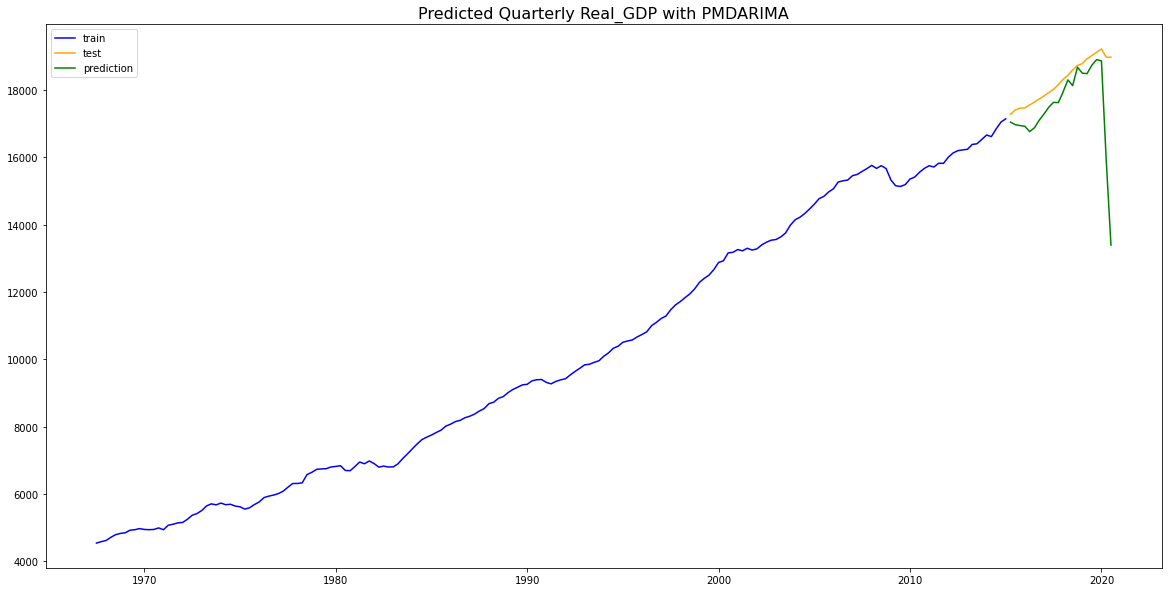

In [225]:
plt.figure(figsize=(20,10))
plt.plot(train_pm.index,train_pm['Real_GDP'], color = 'blue',label='train')
plt.plot(test_pm.index,test_pm['Real_GDP'], color = 'orange',label='test')
plt.plot(test_pm.index,forecasts, color = 'green',label='prediction')
plt.title(label = 'Predicted Quarterly Real_GDP with PMDARIMA', fontsize=16)
plt.legend()
plt.show();

In [226]:
pm_pct_diff=round(((forecasts[-1]/forecasts[-2]-1)*100),3)
pm_pct_diff

-15.915

### Observation 2:

In [227]:
print(f'The Auto-Arima model predicted a {pm_pct_diff}% change in quarterly GDP')

The Auto-Arima model predicted a -15.915% change in quarterly GDP


In [233]:
pm_compare=pd.DataFrame(test['Real_GDP'])

In [234]:
pm_compare['yhat']=forecasts

In [230]:
pm_compare=pm_compare[:-1]

In [235]:
pm_compare.tail()

,Real_GDP,yhat
Date,,
2019-06-30,19021.860,18735.119164
2019-09-30,19121.112,18903.634189
2019-12-31,19221.970,18866.685574
2020-03-31,18974.702,15926.394805
2020-06-30,18974.702,13391.647941


In [232]:
pm_r2=r2_score(pm_compare['Real_GDP'], pm_compare['yhat'])
pm_mse=mean_squared_error(pm_compare['Real_GDP'], pm_compare['yhat'])
pm_rmse = np.sqrt(mse) 
pm_mae=mean_absolute_error(pm_compare['Real_GDP'], pm_compare['yhat'])


print(f'r2: {pm_r2}')
print(f'mean_squared_error: {pm_mse}')
print(f'root_mean_squared_error: {pm_rmse}')
print(f'mean_absolute_error: {pm_mae}')

r2: -0.6307565371810075
mean_squared_error: 644286.5830945303
root_mean_squared_error: 126.17718655821665
mean_absolute_error: 546.2637203428878
